### <center>**Reading and Cleaning Annotation Data for Custom PyTorch Object Detection**</center> 

In [1]:
# Import necessary packages
%matplotlib inline
import json
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion(); # interactive mode

##### Helper functions for processing JSONs

In [2]:
# Function for reading JSON as dictionary
def read_json(filename: str) -> dict:
  
    try:
        with open(filename, "r") as f:
            data = json.loads(f.read())
    except:
        raise Exception(f"Reading {filename} file encountered an error")
  
    return data

# Function to append records to df
def create_dataframe(data: list) -> pd.DataFrame:

    # Create an empty dataframe to append records
    df = pd.DataFrame()
  
    # Looping through each record
    for d in data:
          
        # Normalize the column levels
        record = pd.json_normalize(d)

        df = pd.concat([df, record], axis=0)
          
    return df

# Main function to iterate over files in directory and add to df
def main():
    # Assign directory and empty df for appending annotations
    directory = "C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/Annotations/" # annotation directory
    annos_df = pd.DataFrame()
    
    # Iterate over files in directory
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            print(f)
            
        # Read the JSON file as python dictionary 
        data = read_json(filename = f)
    
        # Create the dataframe for the array items in annotations key 
        df = create_dataframe(data = data['annotations'])
        df.insert(loc = 0, column = 'img_name', value = f'{f[-30:-5]}.JPG')
    
        df.rename(columns = {
            "img_name": "img_name",
            "name": "label",
            "bounding_box.h": "bbox_height",
            "bounding_box.w": "bbox_width",
            "bounding_box.x": "bbox_x_topLeft",
            "bounding_box.y": "bbox_y_topLeft",
            "polygon.paths": "polygon_path"
        }, inplace = True)
        
        # Append the df dataframe to the annos_df dataframe
        annos_df = pd.concat([annos_df, df], ignore_index=True)

    # Convert x, y, h, w to xmin, ymin, xmax, ymax
    annos_df.insert(loc = 2, column = 'xmin', 
                    value = annos_df['bbox_x_topLeft'])
    annos_df.insert(loc = 3, column = 'ymin', 
                    value = annos_df['bbox_y_topLeft'])
    annos_df.insert(loc = 4, column = 'xmax', 
                    value = annos_df['bbox_x_topLeft'] + annos_df['bbox_width'])
    annos_df.insert(loc = 5, column = 'ymax', 
                    value = annos_df['bbox_y_topLeft'] + annos_df['bbox_height']) 
  
    # Drop unneccessary columns 
    annos_df = annos_df.drop(columns = ['bbox_height', 'bbox_width', 'bbox_x_topLeft', 
                                        'bbox_y_topLeft', 'id', 'slot_names', 'polygon_path'])
        
    return annos_df

##### Load annotation data into dataframe

In [ ]:
# Execute main loading function
if __name__ == '__main__':
    df = main()

##### Filter annotation dataframe

In [4]:
# If label value count is less than 200, drop the row
df = df.groupby('label').filter(lambda x : len(x) > 200)

# If label value is 'Hen', drop the row
df = df[df['label'] != 'Hen']

##### Filter images since most annotation class were filtered out

In [5]:
# Store unique img_names in filtered df as array
img_names = df['img_name'].unique().tolist()

# Create a new directory called 'filtered_images'
new_dir = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/filtered_images'
if not os.path.exists(new_dir):
    os.makedirs(new_dir)

# Copy images in img_names to new directory
for img in img_names:
    shutil.copy2(f'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/Images/{img}', new_dir)

### <center>**Transform and Augment Image and Annotation Data for Custom PyTorch Object Detection**</center> 

In [6]:
# import necessary packages
import numpy as np
# from skimage import io
from PIL import Image
from io import BytesIO
from collections import defaultdict
import torch
from torch.utils.data import Dataset
import torch.backends.cudnn as cudnn
cudnn.benchmark = True
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.io import read_image
from torchvision import datapoints as dp
import torchvision.transforms.v2 as T
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights
import utils

##### Pre-process annotation data

In [7]:
# use ordinal encoder to convert df['label'] to numeric values. 0 is reserved for background class.
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()
df.insert(loc = 6, column = 'target', value = (oe.fit_transform(df[['label']])) + 1)

# Create a dictionary using df['label'] as the keys and df['label_code'] as the values
label_dict = dict(zip(df['target'], df['label']))

# Drop label column from df
df = df.drop(['label'], axis = 1)

# Change target column name to label
df.rename(columns = {'target': 'label'}, inplace = True)

# Save df as csv in directory
df.to_csv('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/filtered_annotations.csv', index = False)

##### PyTorch dataset for custom image and annotation data

In [8]:
# Custom dataset loader (PyTorch) for loading images and annotation data
class MAVdroneDataset(Dataset):
    """Dataset Loader for Waterfowl Drone Imagery"""

    def __init__(self, csv_file, root_dir, transforms):
        """
        Arguments:
            csv_file (string): Path to the CSV file with annotations.
            root_dir (string): Directory containing all images.
            transforms (string): train = True for training transforms
        """
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir

        self.transforms = transforms


    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_path = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = None

        while True:
            with open(image_path, 'rb') as f:
                buff = BytesIO()
                buff.write(f.read())
                buff.seek(0)
                temp_image = np.array(Image.open(buff), dtype = np.uint8)
                # convert np.array to Tensor[image_channels, image_height, image_width]
                image = torch.from_numpy(temp_image).permute(2, 0, 1)

            if image is not None:
                break

        boxes = self.df[self.df['img_name'] == self.df.iloc[idx, 0]][['xmin', 'ymin', 'xmax', 'ymax']].values 
        labels = self.df[self.df['img_name'] == self.df.iloc[idx, 0]]['label'].values

        labels = torch.as_tensor(labels, dtype = torch.int64) # (n_objects)

        boxes = torch.as_tensor(boxes, dtype = torch.float32)

        # if xmin > xmax, flip them so width is always positive
        if torch.any(boxes[:, 0] > boxes[:, 2]):
            boxes[:, [0, 2]] = boxes[:, [2, 0]]
        
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((len(labels),), dtype=torch.int64)
            
        target = {}
        target['boxes'] = dp.BoundingBox(boxes, format = "XYXY", spatial_size = (image.shape[1], image.shape[2]))
        target['labels'] = labels
        target['image_id'] = image_id
        target['area'] = area
        target['iscrowd'] = iscrowd

        image = dp.Image(image)

        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target


    def __len__(self):
        return len(self.df['img_name'].unique())

##### Data transformation function

In [9]:
# ImageNet mean and std since using pretrained VGG16 backbone
mean = [0.485, 0.456, 0.406] # 3 bands
std = [0.229, 0.224, 0.225]

# Same transforms as original SSD paper
def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomZoomOut(fill = defaultdict(lambda: 0, {dp.Image: (255, 20, 147)}),
                                          p = 0.3,
                                          side_range = (1.0, 2.0)))
        transforms.append(T.RandomIoUCrop())
        transforms.append(T.Resize((300, 300), antialias = True)) # no maintain aspect ratio
        transforms.append(T.RandomHorizontalFlip(0.5))
    else:
        transforms.append(T.Resize((300, 300), antialias = True)) # no maintain aspect ratio
    transforms.append(T.ToImageTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    transforms.append(T.SanitizeBoundingBox())
    transforms.append(T.Normalize(mean, std)) # ImageNet mean and std values for normalization
    return T.Compose(transforms)

##### Helper functions for plotting image and annotations

In [10]:
# classes are values in label_dict
classes = list(label_dict.values())

# reverse label dictionary for mapping predictions to classes
rev_label_dict = {v: k for k, v in label_dict.items()}

# distinct colors 
distinct_colors = ['#f032e6', '#ffffff', '#ffe119', '#3cb44b', '#42d4f4',
                    '#f58231', '#e6194B', '#dcbeff', '#469990', '#4363d8']

# label color map for plotting color-coded boxes by class
label_color_map = {k: distinct_colors[i] for i, k in enumerate(label_dict.keys())}

# function for reshaping boxes 
def get_box(boxes):
    boxes = np.array(boxes)
    boxes = boxes.astype('float').reshape(-1, 4)
    if boxes.shape[0] == 1 : return boxes
    return np.squeeze(boxes)


# function for plotting image
def img_show(image, ax = None, figsize = (6, 9)):
    if ax is None:
        fig, ax = plt.subplots(figsize = figsize)
    ax.xaxis.tick_top()
    ax.imshow(image)
    return ax
 

def plot_bbox(ax, boxes, labels):
    # add box to the image and use label_color_map to color-code by bounding box class if exists else 'black'
    ax.add_patch(plt.Rectangle((boxes[:, 0], boxes[:, 1]), boxes[:, 2] - boxes[:, 0], boxes[:, 3] - boxes[:, 1],
                    fill = False,
                    color = label_color_map[labels.item()] if labels.item() in label_color_map else 'black', 
                    linewidth = 1.5))
    # add label text to bounding box using label_dict if label exists else labels
    ax.text(boxes[:, 2], boxes[:, 3], 
            (label_dict[labels.item()] if labels.item() in label_dict else labels.item()),
            fontsize = 8,
            bbox = dict(facecolor = 'white', alpha = 0.8, pad = 0, edgecolor = 'none'),
            color = 'black')


# function for plotting all boxes and labels on the image using get_polygon, img_show, and plot_mask functions
def plot_detections(image, boxes, labels, ax = None):
    ax = img_show(image.permute(1, 2, 0), ax = ax)
    for i in range(len(boxes)):
        box = get_box(boxes[i])
        plot_bbox(ax, box, labels[i])

##### Plot sample batch to confirm data loads and transforms correctly

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


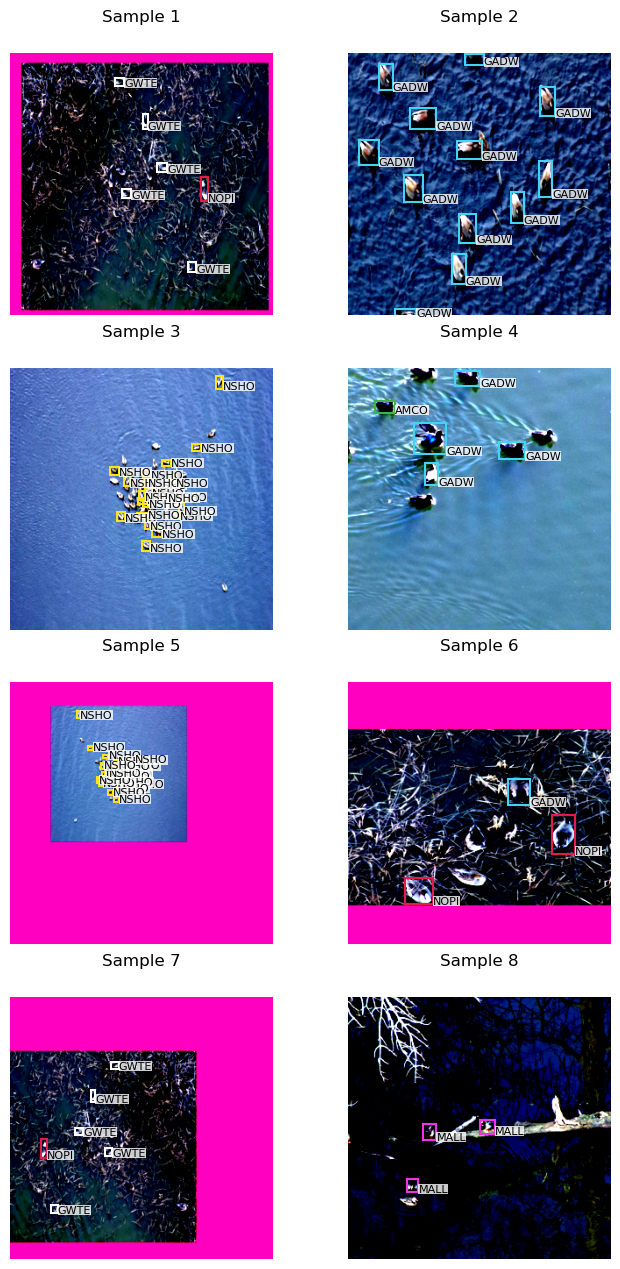

In [11]:
# Load sample batch of filtered annotations and images to custom PyTorch Dataset and Transform
sample_dataset = MAVdroneDataset(csv_file = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/filtered_annotations.csv', 
                                root_dir = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/filtered_images', 
                                transforms = get_transform(train = True))

sample_data_loader = torch.utils.data.DataLoader(sample_dataset, batch_size = 8, shuffle = True, 
                                             collate_fn = utils.collate_fn, num_workers = 0)

# store images and annotation targets from sample batch
images, targets = next(iter(sample_data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

# Plot the all samples from batch in a grid of subplots. 
plt.figure(figsize = (8, 32))
for i in range(8):
    ax = plt.subplot(8, 2, 1 + i)
    plot_detections(images[i], targets[i]['boxes'], targets[i]['labels'], ax = ax)
    plt.axis('off')
    plt.title(f"Sample {i + 1}")

plt.show()

### <center>**Tuning Model Hyperparameters using Ray Tune**</center> 

##### Helper functions for hyperparameter tuning

In [12]:
import tempfile
from datetime import datetime
from engine import train_one_epoch, evaluate
from ray import train, tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search.bayesopt import BayesOptSearch
import torch.nn as nn

In [13]:
# Wrap data loaders in function and pass global data directories. 
def load_data(csv_file = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/filtered_annotations.csv', 
              root_dir = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/filtered_images/'):
    # use MAVdroneDataset and defined transformations
    dataset = MAVdroneDataset(csv_file = csv_file,
                                root_dir = root_dir, 
                                transforms = get_transform(train = True))
    
    dataset_val = MAVdroneDataset(csv_file = csv_file,
                                root_dir = root_dir, 
                                transforms = get_transform(train = False))
    
    indices = torch.arange(len(dataset)).tolist()
    
    return dataset, dataset_val, indices


def train_MAVdroneDataset(config):
    model = ssd300_vgg16(weights = SSD300_VGG16_Weights.DEFAULT, 
                        weights_backbone = 'VGG16_Weights.IMAGENET1K_FEATURES')
    
    device = "cpu" 
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)

    # construct an optimizer 
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr = config["lr"],
                                momentum = config["momentum"], 
                                weight_decay = config["weight_decay"])
    
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size = config["step_size"], # period of lr decay
                                                   gamma = config["gamma"]) # multiplicative factor of lr decay

    # Load existing checkpoint through `get_checkpoint()` API.
    if train.get_checkpoint():
        loaded_checkpoint = train.get_checkpoint()
        with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
            model_state, optimizer_state = torch.load(
                os.path.join(loaded_checkpoint_dir, "checkpoint.pt")
            )
            model.load_state_dict(model_state)
            optimizer.load_state_dict(optimizer_state)

    dataset, dataset_val, indices = load_data()

    # subset using a 80/15/5 split for train, validation, and test datasets
    dataset_train = torch.utils.data.Subset(dataset, indices[:-int(len(dataset)*0.2)]) # first 80% of dataset

    dataset_val = torch.utils.data.Subset(dataset_val, indices[-int(len(dataset)*0.2):-int(len(dataset)*0.05)]) # next 15% of dataset

    training_steps = [
            {"step": 0, "batch_size": 8, "epochs": 10, "print_freq": 40},
            {"step": 1, "batch_size": 32, "epochs": 15, "print_freq": 10}, 
            {"step": 2, "batch_size": 128, "epochs": 15, "print_freq": 3},  
            {"step": 3, "batch_size": 512, "epochs": 5, "print_freq": 1}, 
        ]
    
    start_epoch = 0

    # loop through training_steps during training to increase batch size and decrease learning rate
    for step in training_steps:
        batch_size = step['batch_size']
        num_epochs = step['epochs']
        print_freq = step['print_freq']

        # define training and validation data loaders
        data_loader = torch.utils.data.DataLoader(dataset_train, batch_size = int(batch_size), shuffle = True, 
                                                collate_fn = utils.collate_fn, num_workers = 0,
                                                pin_memory = True)
        
        data_loader_val = torch.utils.data.DataLoader(dataset_val, batch_size = 1, shuffle = False,
                                                    collate_fn = utils.collate_fn, num_workers = 0,
                                                    pin_memory = True)

        print(f'Beginning training step {step["step"]}... batch size: {batch_size}')

        for epoch in range(start_epoch, num_epochs + start_epoch):
            print()
            print(f'Epoch {epoch} beginning training...')
            print()

            # train for one epoch across N accumulation_steps; print every print_freq iterations
            train_metric_logger = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq)

            print()
            print(f'Epoch {epoch} finished training!')
            print()

            # update the learning rate
            lr_scheduler.step()

            print()
            print(f'Epoch {epoch} preparing to evaluate the validation dataset...')
            print()
            
            # evaluate on the val dataset
            coco_val_results = evaluate(model, data_loader_val, device)

            print(f'Epoch {epoch} complete! Moving onto epoch {epoch + 1}...')
            print()

            # Here we save a checkpoint. It is automatically registered with Ray Tune
            with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
                path = os.path.join(temp_checkpoint_dir, "checkpoint.pt")
                torch.save(
                    (model.state_dict(), optimizer.state_dict()), path
                )
                checkpoint = train.Checkpoint.from_directory(temp_checkpoint_dir)
                train.report(
                    {"train_loss": train_metric_logger.loss.value, # metric_logger object,
                    "mAP_50": coco_val_results.coco_eval['bbox'].stats[1], # coco evaluator object (mAP@50)
                    "mAR_100": coco_val_results.coco_eval['bbox'].stats[8],
                    "training_step": step["step"],
                    "epoch": epoch,}, 
                    checkpoint = checkpoint
                )

        print(f'Training step {step["step"]} complete! Moving onto training step {step["step"] + 1}...')
        print()
        
        # set start_epoch to current epoch for next training step
        start_epoch = num_epochs if step['step'] == 0 else num_epochs + start_epoch        
    
    print('Tuning Trial Complete!')


# test set accuracy of best model
def test_best_model(best_result):
    best_trained_model = ssd300_vgg16(weights = SSD300_VGG16_Weights.DEFAULT, 
                        weights_backbone = 'VGG16_Weights.IMAGENET1K_FEATURES')
                                      
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    best_trained_model.to(device)

    checkpoint_path = os.path.join(best_result.checkpoint.to_directory(), "checkpoint.pt")

    model_state, _ = torch.load(checkpoint_path)
    best_trained_model.load_state_dict(model_state)

    _, dataset_test, indices = load_data()

    dataset_test = torch.utils.data.Subset(dataset_test, indices[-int(len(dataset_test)*0.05):]) # last 5% of dataset

    data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size = 1, shuffle = False,
                                                collate_fn = utils.collate_fn, num_workers = 0,
                                                pin_memory = True)
    
    test_results = evaluate(best_trained_model, data_loader_test, device)

    print(f'Best trial test set mAP_50: {test_results.coco_eval["bbox"].stats[1]} and mAR_100: {test_results.coco_eval["bbox"].stats[8]}')


def trial_dirname_creator(trial):
    return f"train_MAVdroneDataset_{trial.trial_id}"


def main(num_samples, max_num_epochs, gpus_per_trial):
    config = {
        "lr": tune.uniform(5e-6, 1.0),
        "momentum": tune.uniform(1e-3, 1.0),
        "weight_decay": tune.uniform(5e-6, 0.5),
        "step_size": tune.uniform(1, 15),
        "gamma": tune.uniform(0.0, 0.9)
    }
     
    scheduler = ASHAScheduler(
        time_attr="epoch",
        max_t=max_num_epochs,
        grace_period=3,
        reduction_factor=2
    )

    bayesopt = BayesOptSearch(
        points_to_evaluate = [
            {"lr": 0.0005, "momentum": 0.9, "weight_decay": 0.0005, "step_size": 3, "gamma": 0.1} 
        ], # Default PyTorch hyperparameter values as starting point for search
        random_search_steps = 10
    )

    tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(train_MAVdroneDataset),
            resources={"cpu": 48, "gpu": gpus_per_trial}
        ),
        run_config=train.RunConfig(
            local_dir='C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results' 
        ),
        tune_config=tune.TuneConfig(
            metric="mAP_50",
            mode="max",
            search_alg = bayesopt,
            scheduler=scheduler,
            num_samples=num_samples,
            trial_dirname_creator=trial_dirname_creator
        ),
        param_space=config
    )

    results = tuner.fit()

    best_result = results.get_best_result("mAP_50", "max")

    print("Best trial config: {}".format(best_result.config))
    print("Best trial final training loss: {}".format(best_result.metrics["train_loss"]))
    print("Best trial final validation mAP_50: {}".format(best_result.metrics["mAP_50"]))
    print("Best trial final validation mAR_100: {}".format(best_result.metrics["mAR_100"]))

    test_best_model(best_result)

    return best_result

if __name__ == "__main__":
    best_trial = main(num_samples=20, max_num_epochs=45, gpus_per_trial=1)

(pid=65240) c:\Users\exx\.conda\envs\SSD_PyTorch\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
(pid=65240)   warnings.warn(_BETA_TRANSFORMS_WARNING)
(pid=65240) c:\Users\exx\.conda\envs\SSD_PyTorch\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedba

(train_MAVdroneDataset pid=65240) Beginning training step 0... batch size: 8
(train_MAVdroneDataset pid=65240) 
(train_MAVdroneDataset pid=65240) Epoch 0 beginning training...
(train_MAVdroneDataset pid=65240) 
(train_MAVdroneDataset pid=65240) Epoch: [0]  [  0/188]  eta: 0:07:57  lr: 0.000003  loss: 13.8375 (13.8375)  bbox_regression: 4.4077 (4.4077)  classification: 9.4298 (9.4298)  time: 2.5395  data: 1.9042  max mem: 1042
(train_MAVdroneDataset pid=65240) Epoch: [0]  [ 40/188]  eta: 0:05:14  lr: 0.000110  loss: 7.1768 (8.9334)  bbox_regression: 2.0276 (2.1310)  classification: 4.9899 (6.8023)  time: 2.0992  data: 1.8913  max mem: 1211
(train_MAVdroneDataset pid=65240) Epoch: [0]  [ 80/188]  eta: 0:03:48  lr: 0.000217  loss: 5.6022 (7.4976)  bbox_regression: 1.6599 (1.9557)  classification: 4.0596 (5.5419)  time: 2.1247  data: 1.9078  max mem: 1212
(train_MAVdroneDataset pid=65240) Epoch: [0]  [120/188]  eta: 0:02:23  lr: 0.000324  loss: 5.0951 (6.7991)  bbox_regression: 1.2854 (1.8

(train_MAVdroneDataset pid=65240) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-08-08_20-49-52/train_MAVdroneDataset_5adc1165/checkpoint_000000)


(train_MAVdroneDataset pid=65240) 
(train_MAVdroneDataset pid=65240) Epoch 1 beginning training...
(train_MAVdroneDataset pid=65240) 
(train_MAVdroneDataset pid=65240) Epoch: [1]  [  0/188]  eta: 0:06:28  lr: 0.000500  loss: 4.3991 (4.3991)  bbox_regression: 0.9006 (0.9006)  classification: 3.4984 (3.4984)  time: 2.0689  data: 1.7278  max mem: 1212
(train_MAVdroneDataset pid=65240) Epoch: [1]  [ 40/188]  eta: 0:05:08  lr: 0.000500  loss: 4.0203 (4.4730)  bbox_regression: 1.1410 (1.2962)  classification: 2.9011 (3.1768)  time: 2.0850  data: 1.8820  max mem: 1212
(train_MAVdroneDataset pid=65240) Epoch: [1]  [ 80/188]  eta: 0:03:44  lr: 0.000500  loss: 3.9504 (4.3415)  bbox_regression: 1.0260 (1.2621)  classification: 2.7927 (3.0794)  time: 2.0683  data: 1.8815  max mem: 1212
(train_MAVdroneDataset pid=65240) Epoch: [1]  [120/188]  eta: 0:02:21  lr: 0.000500  loss: 3.9006 (4.1700)  bbox_regression: 1.0511 (1.1865)  classification: 2.7357 (2.9835)  time: 2.1258  data: 1.9147  max mem: 121

(train_MAVdroneDataset pid=65240) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-08-08_20-49-52/train_MAVdroneDataset_5adc1165/checkpoint_000001)


(train_MAVdroneDataset pid=65240) 
(train_MAVdroneDataset pid=65240) Epoch 2 beginning training...
(train_MAVdroneDataset pid=65240) 
(train_MAVdroneDataset pid=65240) Epoch: [2]  [  0/188]  eta: 0:06:21  lr: 0.000500  loss: 4.5021 (4.5021)  bbox_regression: 1.6920 (1.6920)  classification: 2.8102 (2.8102)  time: 2.0295  data: 1.7685  max mem: 1212
(train_MAVdroneDataset pid=65240) Epoch: [2]  [ 40/188]  eta: 0:04:52  lr: 0.000500  loss: 3.8111 (3.8068)  bbox_regression: 1.0110 (1.0933)  classification: 2.5731 (2.7135)  time: 1.9730  data: 1.7937  max mem: 1212
(train_MAVdroneDataset pid=65240) Epoch: [2]  [ 80/188]  eta: 0:03:33  lr: 0.000500  loss: 3.6391 (3.7153)  bbox_regression: 0.8865 (1.0322)  classification: 2.6942 (2.6831)  time: 2.0050  data: 1.8157  max mem: 1212
(train_MAVdroneDataset pid=65240) Epoch: [2]  [120/188]  eta: 0:02:15  lr: 0.000500  loss: 3.5283 (3.6488)  bbox_regression: 0.8644 (0.9748)  classification: 2.6137 (2.6740)  time: 1.9850  data: 1.8112  max mem: 121

(train_MAVdroneDataset pid=65240) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-08-08_20-49-52/train_MAVdroneDataset_5adc1165/checkpoint_000002)


(train_MAVdroneDataset pid=65240) 
(train_MAVdroneDataset pid=65240) Epoch 3 beginning training...
(train_MAVdroneDataset pid=65240) 
(train_MAVdroneDataset pid=65240) Epoch: [3]  [  0/188]  eta: 0:06:41  lr: 0.000050  loss: 2.8435 (2.8435)  bbox_regression: 0.4970 (0.4970)  classification: 2.3465 (2.3465)  time: 2.1377  data: 1.8568  max mem: 1212
(train_MAVdroneDataset pid=65240) Epoch: [3]  [ 40/188]  eta: 0:04:58  lr: 0.000050  loss: 3.1191 (3.3326)  bbox_regression: 0.7415 (0.8626)  classification: 2.3554 (2.4700)  time: 2.0115  data: 1.8197  max mem: 1212
(train_MAVdroneDataset pid=65240) Epoch: [3]  [ 80/188]  eta: 0:03:36  lr: 0.000050  loss: 3.2262 (3.2677)  bbox_regression: 0.6839 (0.8322)  classification: 2.4460 (2.4356)  time: 2.0049  data: 1.8168  max mem: 1212
(train_MAVdroneDataset pid=65240) Epoch: [3]  [120/188]  eta: 0:02:16  lr: 0.000050  loss: 3.0184 (3.2235)  bbox_regression: 0.7314 (0.8191)  classification: 2.2108 (2.4044)  time: 1.9899  data: 1.8014  max mem: 121

(train_MAVdroneDataset pid=65240) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-08-08_20-49-52/train_MAVdroneDataset_5adc1165/checkpoint_000003)


(train_MAVdroneDataset pid=65240) 
(train_MAVdroneDataset pid=65240) Epoch 4 beginning training...
(train_MAVdroneDataset pid=65240) 
(train_MAVdroneDataset pid=65240) Epoch: [4]  [  0/188]  eta: 0:06:57  lr: 0.000050  loss: 3.3879 (3.3879)  bbox_regression: 0.9366 (0.9366)  classification: 2.4513 (2.4513)  time: 2.2224  data: 1.8859  max mem: 1212
(train_MAVdroneDataset pid=65240) Epoch: [4]  [ 40/188]  eta: 0:04:59  lr: 0.000050  loss: 3.1544 (3.1665)  bbox_regression: 0.6140 (0.7473)  classification: 2.3968 (2.4192)  time: 2.0589  data: 1.8548  max mem: 1212
(train_MAVdroneDataset pid=65240) Epoch: [4]  [ 80/188]  eta: 0:03:37  lr: 0.000050  loss: 2.9251 (3.1149)  bbox_regression: 0.6670 (0.7350)  classification: 2.2173 (2.3798)  time: 2.0150  data: 1.8265  max mem: 1212
(train_MAVdroneDataset pid=65240) Epoch: [4]  [120/188]  eta: 0:02:16  lr: 0.000050  loss: 3.1553 (3.1326)  bbox_regression: 0.6475 (0.7455)  classification: 2.4239 (2.3871)  time: 2.0224  data: 1.8307  max mem: 121

(train_MAVdroneDataset pid=65240) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-08-08_20-49-52/train_MAVdroneDataset_5adc1165/checkpoint_000004)


(train_MAVdroneDataset pid=65240) 
(train_MAVdroneDataset pid=65240) Epoch 5 beginning training...
(train_MAVdroneDataset pid=65240) 
(train_MAVdroneDataset pid=65240) Epoch: [5]  [  0/188]  eta: 0:05:57  lr: 0.000050  loss: 2.7144 (2.7144)  bbox_regression: 0.5539 (0.5539)  classification: 2.1605 (2.1605)  time: 1.9042  data: 1.6558  max mem: 1212
(train_MAVdroneDataset pid=65240) Epoch: [5]  [ 40/188]  eta: 0:04:53  lr: 0.000050  loss: 3.0545 (2.9600)  bbox_regression: 0.6986 (0.6804)  classification: 2.3368 (2.2796)  time: 1.9816  data: 1.8112  max mem: 1212
(train_MAVdroneDataset pid=65240) Epoch: [5]  [ 80/188]  eta: 0:03:36  lr: 0.000050  loss: 3.0629 (3.1303)  bbox_regression: 0.6647 (0.7598)  classification: 2.3673 (2.3706)  time: 2.0405  data: 1.8484  max mem: 1212
(train_MAVdroneDataset pid=65240) Epoch: [5]  [120/188]  eta: 0:02:16  lr: 0.000050  loss: 2.8867 (3.0960)  bbox_regression: 0.5340 (0.7407)  classification: 2.3429 (2.3553)  time: 1.9657  data: 1.7897  max mem: 121

(train_MAVdroneDataset pid=65240) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-08-08_20-49-52/train_MAVdroneDataset_5adc1165/checkpoint_000005)


(train_MAVdroneDataset pid=65240) 
(train_MAVdroneDataset pid=65240) Epoch 6 beginning training...
(train_MAVdroneDataset pid=65240) 
(train_MAVdroneDataset pid=65240) Epoch: [6]  [  0/188]  eta: 0:06:36  lr: 0.000005  loss: 3.7554 (3.7554)  bbox_regression: 0.9612 (0.9612)  classification: 2.7942 (2.7942)  time: 2.1077  data: 1.8256  max mem: 1212
(train_MAVdroneDataset pid=65240) Epoch: [6]  [ 40/188]  eta: 0:04:59  lr: 0.000005  loss: 3.0449 (3.1546)  bbox_regression: 0.6329 (0.7799)  classification: 2.3105 (2.3747)  time: 2.0183  data: 1.8367  max mem: 1212
(train_MAVdroneDataset pid=65240) Epoch: [6]  [ 80/188]  eta: 0:03:37  lr: 0.000005  loss: 3.1146 (3.1190)  bbox_regression: 0.6305 (0.7627)  classification: 2.3772 (2.3564)  time: 2.0038  data: 1.8189  max mem: 1212
(train_MAVdroneDataset pid=65240) Epoch: [6]  [120/188]  eta: 0:02:16  lr: 0.000005  loss: 3.0087 (3.1082)  bbox_regression: 0.7239 (0.7678)  classification: 2.3008 (2.3404)  time: 2.0289  data: 1.8334  max mem: 121

(train_MAVdroneDataset pid=65240) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-08-08_20-49-52/train_MAVdroneDataset_5adc1165/checkpoint_000006)


(train_MAVdroneDataset pid=65240) 
(train_MAVdroneDataset pid=65240) Epoch 7 beginning training...
(train_MAVdroneDataset pid=65240) 
(train_MAVdroneDataset pid=65240) Epoch: [7]  [  0/188]  eta: 0:06:30  lr: 0.000005  loss: 2.1399 (2.1399)  bbox_regression: 0.3815 (0.3815)  classification: 1.7584 (1.7584)  time: 2.0783  data: 1.8227  max mem: 1212
(train_MAVdroneDataset pid=65240) Epoch: [7]  [ 40/188]  eta: 0:04:52  lr: 0.000005  loss: 3.1599 (3.0625)  bbox_regression: 0.7804 (0.7507)  classification: 2.2196 (2.3117)  time: 1.9820  data: 1.8015  max mem: 1212
(train_MAVdroneDataset pid=65240) Epoch: [7]  [ 80/188]  eta: 0:03:36  lr: 0.000005  loss: 3.0276 (3.0459)  bbox_regression: 0.5791 (0.7462)  classification: 2.2550 (2.2996)  time: 2.0620  data: 1.8646  max mem: 1212
(train_MAVdroneDataset pid=65240) Epoch: [7]  [120/188]  eta: 0:02:17  lr: 0.000005  loss: 2.9243 (3.0390)  bbox_regression: 0.5819 (0.7344)  classification: 2.2988 (2.3046)  time: 2.0678  data: 1.8768  max mem: 121

(train_MAVdroneDataset pid=65240) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-08-08_20-49-52/train_MAVdroneDataset_5adc1165/checkpoint_000007)


(train_MAVdroneDataset pid=65240) 
(train_MAVdroneDataset pid=65240) Epoch 8 beginning training...
(train_MAVdroneDataset pid=65240) 
(train_MAVdroneDataset pid=65240) Epoch: [8]  [  0/188]  eta: 0:06:31  lr: 0.000005  loss: 3.6771 (3.6771)  bbox_regression: 0.7811 (0.7811)  classification: 2.8959 (2.8959)  time: 2.0835  data: 1.8398  max mem: 1212
(train_MAVdroneDataset pid=65240) Epoch: [8]  [ 40/188]  eta: 0:05:02  lr: 0.000005  loss: 2.8957 (3.0577)  bbox_regression: 0.7220 (0.7151)  classification: 2.2643 (2.3426)  time: 2.0508  data: 1.8534  max mem: 1212
(train_MAVdroneDataset pid=65240) Epoch: [8]  [ 80/188]  eta: 0:03:41  lr: 0.000005  loss: 3.0966 (3.1273)  bbox_regression: 0.7120 (0.7578)  classification: 2.4065 (2.3694)  time: 2.0759  data: 1.8750  max mem: 1212


### <center>**Train Model Using Tuned Hyperparameters**</center> 

In [ ]:
from torch.utils.tensorboard import SummaryWriter

torch.cuda.empty_cache() 

# Hyperparameters are best trial results from Bayesian Optimization using Ray Tune
learning_rate = best_trial.config["lr"]
momentum = best_trial.config["momentum"]
weight_decay = best_trial.config["weight_decay"]
step_size = best_trial.config["step_size"]
gamma = best_trial.config["gamma"]

# # User-defined hyperparameters / uncomment if want to define manually [pytorch defaults]
# learning_rate = 0.0005
# momentum = 0.9
# weight_decay = 0.0005
# step_size = 3
# gamma = 0.1

# Hyperparameter values for each training step; batch_size increases by a factor of 4 at each step
# accumulation steps is N batches to accumulate gradients for before zeroing gradients
# training_steps = [
#     {"step": 0, "batch_size": 8, "lr": learning_rate, "epochs": 15, "print_freq": 20, 'accumulation_steps': 1}, 
#     {"step": 1, "batch_size": 32, "lr": learning_rate, "epochs": 15, "print_freq": 5, 'accumulation_steps': 1},
#     {"step": 2, "batch_size": 128, "lr": learning_rate, "epochs": 10, "print_freq": 5, 'accumulation_steps': 1}, # gpu memory maxes out at batch size 64
#     {"step": 3, "batch_size": 512, "lr": learning_rate, "epochs": 5, "print_freq": 5, 'accumulation_steps': 1}, # batch size 1024 via gradient accumulation
# ]

# no gradient accumulation
training_steps = [
            {"step": 0, "batch_size": 8, "lr": learning_rate, "epochs": 10, "print_freq": 80},
            {"step": 1, "batch_size": 32, "lr": learning_rate, "epochs": 15, "print_freq": 20}, 
            {"step": 2, "batch_size": 128, "lr": learning_rate, "epochs": 15, "print_freq": 5}, 
            {"step": 3, "batch_size": 512, "lr": learning_rate, "epochs": 5, "print_freq": 1}, 
]

# Main function that performs training and validation.
def main():
    # train on the GPU, or on CPU if GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    print(f'Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else "cpu"}')
    print()

    # Initialize model--SSD300 w/ VGG16 backbone pre-trained
    model = ssd300_vgg16(weights = SSD300_VGG16_Weights.DEFAULT, 
                        weights_backbone = 'VGG16_Weights.IMAGENET1K_FEATURES')

    # move model to device
    model.to(device)

    start_epoch = 0

    # initialize tensorboard writer
    writer = SummaryWriter()

    # Store one checkpoint dictionary for each epoch in a list of dictionaries. 
    checkpoints = []

    # loop through training_steps during training to increase batch size and decrease learning rate
    for step in training_steps:
        batch_size = step['batch_size']
        lr = step['lr']
        num_epochs = step['epochs']
        print_freq = step['print_freq']
        # accumulation_steps = step['accumulation_steps']
    
        # use MAVdroneDataset and defined transformations
        dataset = MAVdroneDataset(csv_file = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/filtered_annotations.csv',
                                root_dir = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/filtered_images/', 
                                transforms = get_transform(train = True))
        
        dataset_val = MAVdroneDataset(csv_file = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/filtered_annotations.csv',
                                root_dir = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/filtered_images/',
                                transforms = get_transform(train = False))
        
        # store indices in random order list
        indices = torch.randperm(len(dataset_val)).tolist()

        # subset using a 80/15/5 split for train, validation, and test datasets
        dataset = torch.utils.data.Subset(dataset, indices[:-int(len(dataset)*0.2)])

        dataset_val = torch.utils.data.Subset(dataset_val, indices[-int(len(dataset_val)*0.2):-int(len(dataset_val)*0.05)])

        # define training and validation data loaders
        data_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True, 
                                                collate_fn = utils.collate_fn, num_workers = 0,
                                                pin_memory = True)
        
        data_loader_val = torch.utils.data.DataLoader(dataset_val, batch_size = 1, shuffle = False,
                                                    collate_fn = utils.collate_fn, num_workers = 0,
                                                    pin_memory = True)
        
        # construct an optimizer - SGD w/ momentum and weight decay
        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(params, lr = lr,
                                    momentum = momentum, weight_decay = weight_decay)
        
        # and a learning rate scheduler
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                    step_size = step_size,
                                                    gamma = gamma)
        
        # Log the hyperparameters to tensorboard
        writer.add_hparams(
            # {"lr": lr, "momentum": momentum, "weight_decay": weight_decay, "step_size": step_size, "gamma": gamma, "batch_size": (batch_size*accumulation_steps)},
            {"lr": lr, "momentum": momentum, "weight_decay": weight_decay, "step_size": step_size, "gamma": gamma, "batch_size": (batch_size)},
            {}
        )
        
        # print(f'Beginning training step {step["step"]}... batch size: {batch_size*accumulation_steps}')
        print(f'Beginning training step {step["step"]}... batch size: {batch_size}')

        #########################################################
        ##               The main training loop                ##
        #########################################################
        for epoch in range(start_epoch, num_epochs + start_epoch):
            print()
            print(f'Epoch {epoch} beginning training...')
            print()
            
            # train for one epoch across N accumulation_steps; print every print_freq iterations
            # train_metric_logger = train_one_epoch(model, optimizer, data_loader, accumulation_steps, device, epoch, print_freq)
            train_metric_logger = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq)

            print()
            print(f'Epoch {epoch} finished training!')
            print()

            # update the learning rate
            lr_scheduler.step()

            print()
            print(f'Epoch {epoch} preparing to evaluate the validation dataset...')
            print()
            
            # evaluate on the validation dataset
            coco_eval_results = evaluate(model, data_loader_val, device)

            # store training and validation metrics in checkpoint dictionary. 
            checkpoint = {
                "epoch": epoch,
                "loss": train_metric_logger.loss.value, # metric_logger object
                "bbox_loss": train_metric_logger.bbox_regression.value,
                "class_loss": train_metric_logger.classification.value,
                "mAP": coco_eval_results.coco_eval['bbox'].stats[0], # coco evaluator object
                "mAP_50": coco_eval_results.coco_eval['bbox'].stats[1],
                "mAP_75": coco_eval_results.coco_eval['bbox'].stats[2],
                "mAP_small": coco_eval_results.coco_eval['bbox'].stats[3],
                "mAP_medium": coco_eval_results.coco_eval['bbox'].stats[4],
                "mAP_large": coco_eval_results.coco_eval['bbox'].stats[5],
                "mAR_1": coco_eval_results.coco_eval['bbox'].stats[6],
                "mAR_10": coco_eval_results.coco_eval['bbox'].stats[7],
                "mAR_100": coco_eval_results.coco_eval['bbox'].stats[8],
                "mAR_small": coco_eval_results.coco_eval['bbox'].stats[9],
                "mAR_medium": coco_eval_results.coco_eval['bbox'].stats[10],
                "mAR_large": coco_eval_results.coco_eval['bbox'].stats[11],
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict()
            }

            # append checkpoint to checkpoints list
            checkpoints.append(checkpoint)

            # report training and validation scalars to tensorboard
            writer.add_scalar('Total Loss/train', np.array(float(checkpoint["loss"])), epoch)
            writer.add_scalar('Regression Loss/train', np.array(float(checkpoint["bbox_loss"])), epoch)
            writer.add_scalar('Classification Loss/train', np.array(float(checkpoint["class_loss"])), epoch)
            writer.add_scalar('Accuracy/val (mAP@50)', np.array(float(checkpoint["mAP_50"])), epoch)
            writer.add_scalar('Accuracy/val (mAP@75)', np.array(float(checkpoint["mAP_75"])), epoch)
            writer.add_scalar('Accuracy/val (mAR@100)', np.array(float(checkpoint["mAR_100"])), epoch)

            print()
            print(f'Epoch {epoch} complete! Moving onto epoch {epoch + 1}...')
            print()
        
        print()
        print(f'Training step {step["step"]} complete! Moving onto training step {step["step"] + 1}...')
        print()

        # set start_epoch to current epoch for next training step
        start_epoch = num_epochs if step['step'] == 0 else num_epochs + start_epoch

    print('All Training Steps Complete!')

    # close tensorboard writer
    writer.close()

    return checkpoints, indices

if __name__ == "__main__":
    checkpoints, indices = main()

In [ ]:
# Best train epoch is dictionary in checkpoints with highest mAP_50 value
best_train_epoch = max(checkpoints, key = lambda x: x['mAP_50'])

# initialize SSD VGG16 pre-trained model
model = ssd300_vgg16()

# load model weights from best_train_epoch
model.load_state_dict(best_train_epoch["model_state_dict"])

# save model weights to .pth file
torch.save(model.state_dict(), 'SSD_VGG16_final_' + str(datetime.now().strftime("%m%d%Y")) + '.pth')

### <center>**Model Inference on Test Dataset**</center> 

In [ ]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

##### Load the test dataset

In [ ]:
dataset_test = MAVdroneDataset(csv_file = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/filtered_annotations.csv',
                                root_dir = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/filtered_images/', 
                                transforms = get_transform(train = False))

# indices returned from main training function for subsetting 
image_names = dataset_test.df.iloc[indices, 0]

# subset image_names pandas series to last 5% for test dataset images
test_image_names = image_names[-int(len(image_names)*0.05):]

# last 5% of dataset for testing
dataset_test = torch.utils.data.Subset(dataset_test, indices[-int(len(dataset_test)*0.05):])

data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size = 1, shuffle = False,
                                                collate_fn = utils.collate_fn, num_workers = 0)

In [ ]:
test_performance = evaluate(model, data_loader_test, device=torch.device('cuda'))
print(test_performance)

##### Calculate performance metrics on every image in test dataset

In [ ]:
results = []

metric = MeanAveragePrecision(iou_type="bbox",
                              class_metrics=True,
                              max_detection_thresholds=[1, 10, 100, 1000])

model.to('cpu')
model.eval()

for images, targets in data_loader_test:
    # use image_id to get image_name from image_names list
    image_id = [target['image_id'].item() for target in targets]

    # convert boxes in targets to tensors
    targets = [{k: torch.tensor(v) if k == 'boxes' else v for k, v in t.items()} for t in targets]

    # filter targets to only include boxes and labels keys
    ground_truth = [{k: v for k, v in t.items() if k in ('boxes', 'labels')} for t in targets]

    with torch.no_grad():
        prediction = model(images, targets)

    # calculate mAP and mAR from test dataset
    metric.update(prediction, ground_truth)
    mean_AP = metric.compute()

    # append image name to mean_AP
    mean_AP['image_name'] = test_image_names[image_id[0]]

    # Append mean_AP and predictions to results list. 
    results.append(mean_AP)

##### Store per-image test dataset metrics as dataframe

In [ ]:
# use pandas to create a dataframe of image names and mAP values
img_results_df = pd.DataFrame()
img_results_df['image_name'] = [result['image_name'] for result in results]
img_results_df['mAP'] = [result['map'].item() for result in results]
img_results_df['mAP_50'] = [result['map_50'].item() for result in results]
img_results_df['mAP_75'] = [result['map_75'].item() for result in results]
img_results_df['mAP_small'] = [result['map_small'].item() for result in results]
img_results_df['mAP_medium'] = [result['map_medium'].item() for result in results]
img_results_df['mAP_large'] = [result['map_large'].item() for result in results]
img_results_df['mAR_1'] = [result['mar_1'].item() for result in results]
img_results_df['mAR_10'] = [result['mar_10'].item() for result in results]
img_results_df['mAR_100'] = [result['mar_100'].item() for result in results]
img_results_df['mAR_small'] = [result['mar_small'].item() for result in results]
img_results_df['mAR_medium'] = [result['mar_medium'].item() for result in results]
img_results_df['mAR_large'] = [result['mar_large'].item() for result in results]

# if value is == -1.0, replace with NaN
img_results_df = img_results_df.replace(-1.0, np.nan)

##### Print per-image metrics for test dataset as table

In [ ]:
from prettytable import PrettyTable
cols = ['Value', 'mAP_50', 'mAP_75', 'mAR_100']

# create a pretty table object
x = PrettyTable()

# add column headers
x.field_names = cols

# add row values
x.add_row(['Mean', img_results_df['mAP_50'].mean(), img_results_df['mAP_75'].mean(), img_results_df['mAR_100'].mean()])
x.add_row(['Median', img_results_df['mAP_50'].median(), img_results_df['mAP_75'].median(), img_results_df['mAR_100'].median()])
x.add_row(['Std', img_results_df['mAP_50'].std(), img_results_df['mAP_75'].std(), img_results_df['mAR_100'].std()])
x.add_row(['Min', img_results_df['mAP_50'].min(), img_results_df['mAP_75'].min(), img_results_df['mAR_100'].min()])
x.add_row(['Max', img_results_df['mAP_50'].max(), img_results_df['mAP_75'].max(), img_results_df['mAR_100'].max()])

# print table
print(x)

# save table as txt file
with open('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/testDataset_image_summary_results.txt', 'w') as f:
    print(x, file = f)

# save results_df to csv
img_results_df.to_csv('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/per_image_results.csv', index = False)

##### Store per-class test dataset metrics as dataframe

In [ ]:
class_res_df = pd.DataFrame()

# store 'map_per_class' and 'mar_100_per_class' from results in df
class_res_df['image_name'] = [result['image_name'] for result in results]
class_res_df['classes'] = [result['classes'] for result in results]
class_res_df['map_per_class'] = [result['map_per_class'] for result in results]
class_res_df['mar_100_per_class'] = [result['mar_100_per_class'] for result in results]

# convert tensors to numpy arrays
class_res_df['classes'] = class_res_df['classes'].apply(lambda x: x.numpy())
class_res_df['map_per_class'] = class_res_df['map_per_class'].apply(lambda x: x.numpy())
class_res_df['mar_100_per_class'] = class_res_df['mar_100_per_class'].apply(lambda x: x.numpy())

# replace integer labels in classes column with labels using label_dict
class_res_df['classes'] = class_res_df['classes'].apply(lambda x: [label_dict.get(i) for i in x])

# replace -1.0 values in map_per_class and mar_100_per_class with NaN
class_res_df['map_per_class'] = class_res_df['map_per_class'].apply(lambda x: np.where(x == -1.0, np.nan, x))
class_res_df['mar_100_per_class'] = class_res_df['mar_100_per_class'].apply(lambda x: np.where(x == -1.0, np.nan, x))

##### Print per-class metrics for every image in test dataset as table

In [ ]:
# cols = 'value' and all unique classes
cols = ['Class', 'mAP', 'mAR_100']

# create a pretty table object
x = PrettyTable()

# add column headers
x.field_names = cols

# unique classes go in the first 'Class' column.
# mean mAP and mAR_100 values of each class in column one go in the second and third columns.
for i, c in enumerate(list(class_res_df['classes'][0])):
    # Only add rows for classes that are in label_dict
    if c in label_dict.values():
        x.add_row([c, np.nanmean(class_res_df['map_per_class'].apply(lambda x: x[i])), np.nanmean(class_res_df['mar_100_per_class'].apply(lambda x: x[i]))])

# print table
print(x)

# save table as txt file
with open('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/testDataset_class_summary_results.txt', 'w') as f:
    print(x, file = f)

# save results_df to csv
class_res_df.to_csv('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/per_class_results.csv', index = False)

### <center>**Plot Model Predictions for Images in Test Dataset**</center> 

##### Helper functions for plotting predicitions on original images

In [ ]:
def plot_bbox_predicted(ax, boxes, labels, scores): # modify plot_bbox to add confidence scores
    # add box to the image and use label_color_map to color-code by bounding box class if exists else 'black'
    ax.add_patch(plt.Rectangle((boxes[:, 0], boxes[:, 1]), boxes[:, 2] - boxes[:, 0], boxes[:, 3] - boxes[:, 1],
                    fill = False,
                    color = label_color_map[labels.item()] if labels.item() in label_color_map else 'black', 
                    linewidth = 1.5))
    
    # add label and score to the bounding box. concatenate label and score to one string. 
    # use label_dict to replace class numbers with class names
    ax.text(boxes[:, 0], boxes[:, 1] - 100,
        s = f"{label_dict[labels.item()]} {scores.item():.2f}",
        color = 'black',
        fontsize = 6,
        verticalalignment = 'top',
        bbox = {'color': label_color_map[labels.item()] if labels.item() in label_color_map else 'black', 'pad': 0})
    return ax


# function for plotting all predictions on images
def plot_predictions(image, boxes, labels, scores, ax = None):
    ax = img_show(image, ax = ax)
    for i in range(len(boxes)):
        box = get_box(boxes[i])
        plot_bbox_predicted(ax, box, labels[i], scores[i])

##### Load test data into single batch containing all test images

In [ ]:
# load entire test dataset into one batch
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size = int(len(test_image_names)), shuffle = False,
                                                collate_fn = utils.collate_fn, num_workers = 0)

# run predictions on the test dataset
images, targets = next(iter(data_loader_test))

images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

# convert boxes in targets to tensors
targets = [{k: torch.tensor(v) if k == 'boxes' else v for k, v in t.items()} for t in targets]

# filter targets to only include boxes and labels keys
ground_truth = [{k: v for k, v in t.items() if k in ('boxes', 'labels')} for t in targets]

model.to('cpu')

model.eval()

with torch.no_grad():
    predictions = model(images, targets) 

In [ ]:
# Repeat performance metrics on data_loader_test as single batch. 
metric = MeanAveragePrecision(iou_type="bbox",
                              class_metrics=True,
                              max_detection_thresholds=[1, 10, 100, 1000])

metric.update(predictions, targets)
mean_AP_singleBatch = metric.compute()

##### Calculate performance metrics on entire test dataset

In [ ]:
# Store Per-batch metrics in a dataframe
single_batch_df = pd.DataFrame()
single_batch_df['mAP'] = [mean_AP_singleBatch['map'].item()]
single_batch_df['mAP_50'] = [mean_AP_singleBatch['map_50'].item()]
single_batch_df['mAP_75'] = [mean_AP_singleBatch['map_75'].item()]
single_batch_df['mAP_small'] = [mean_AP_singleBatch['map_small'].item()]
single_batch_df['mAP_medium'] = [mean_AP_singleBatch['map_medium'].item()]
single_batch_df['mAP_large'] = [mean_AP_singleBatch['map_large'].item()]
single_batch_df['mAR_1'] = [mean_AP_singleBatch['mar_1'].item()]
single_batch_df['mAR_10'] = [mean_AP_singleBatch['mar_10'].item()]
single_batch_df['mAR_100'] = [mean_AP_singleBatch['mar_100'].item()]
single_batch_df['mAR_small'] = [mean_AP_singleBatch['mar_small'].item()]
single_batch_df['mAR_medium'] = [mean_AP_singleBatch['mar_medium'].item()]
single_batch_df['mAR_large'] = [mean_AP_singleBatch['mar_large'].item()]

# if value is == -1.0, replace with NaN
single_batch_df = single_batch_df.replace(-1.0, np.nan)

# save single_batch_df to csv
single_batch_df.to_csv('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/single_batch_results.csv', index = False)

##### Print performance metrics on entire test dataset as table

In [ ]:
# print single_batch_df as a pretty table
# cols = columns in single_batch_df
cols = ['Metric', 'Value']

# create a pretty table object
x = PrettyTable()

# add column headers
x.field_names = cols

# add row values
x.add_row(['mAP', single_batch_df['mAP'].item()])
x.add_row(['mAP 50', single_batch_df['mAP_50'].item()])
x.add_row(['mAP 75', single_batch_df['mAP_75'].item()])
x.add_row(['mAP Small', single_batch_df['mAP_small'].item()])
x.add_row(['mAP Medium', single_batch_df['mAP_medium'].item()])
x.add_row(['mAP Large', single_batch_df['mAP_large'].item()])
x.add_row(['mAR 1', single_batch_df['mAR_1'].item()])
x.add_row(['mAR 10', single_batch_df['mAR_10'].item()])
x.add_row(['mAR 100', single_batch_df['mAR_100'].item()])
x.add_row(['mAR Small', single_batch_df['mAR_small'].item()])
x.add_row(['mAR Medium', single_batch_df['mAR_medium'].item()])
x.add_row(['mAR Large', single_batch_df['mAR_large'].item()])

print(x)

##### Calculate per-class performance metrics on entire test dataset

In [ ]:
# Store per-batch class metrics in a dataframe
class_res_singleBatch_df = pd.DataFrame()

# store 'map_per_class' and 'mar_100_per_class' from results in df
class_res_singleBatch_df['classes'] = [mean_AP_singleBatch['classes']]
class_res_singleBatch_df['map_per_class'] = [mean_AP_singleBatch['map_per_class']]
class_res_singleBatch_df['mar_100_per_class'] = [mean_AP_singleBatch['mar_100_per_class']]

# convert tensors to numpy arrays
class_res_singleBatch_df['classes'] = class_res_singleBatch_df['classes'].apply(lambda x: x.numpy())
class_res_singleBatch_df['map_per_class'] = class_res_singleBatch_df['map_per_class'].apply(lambda x: x.numpy())
class_res_singleBatch_df['mar_100_per_class'] = class_res_singleBatch_df['mar_100_per_class'].apply(lambda x: x.numpy())

# reference label_dict to remove numeric class values not in label_dict keys
class_res_singleBatch_df['classes'] = class_res_singleBatch_df['classes'].apply(lambda x: [label_dict.get(i) for i in x])

# remove -1.0 values in map_per_class and mar_100_per_class
class_res_singleBatch_df['map_per_class'] = class_res_singleBatch_df['map_per_class'].apply(lambda x: np.where(x == -1.0, np.nan, x))
class_res_singleBatch_df['mar_100_per_class'] = class_res_singleBatch_df['mar_100_per_class'].apply(lambda x: np.where(x == -1.0, np.nan, x))

# remove classes is None
class_res_singleBatch_df = class_res_singleBatch_df[class_res_singleBatch_df['classes'].apply(lambda x: x is not None)]

# Save class_res_singleBatch_df to csv
class_res_singleBatch_df.to_csv('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/per_class_singleBatch_results.csv', index = False)

##### Print per-class performance metrics for entire test dataset as table

In [ ]:
# print class_res_singleBatch_df as a pretty table
# cols = columns in class_res_singleBatch_df
cols = ['Class', 'mAP', 'mAR_100']

# create a pretty table object
x = PrettyTable()

# add column headers
x.field_names = cols

# unique classes go in the first 'Class' column.
# mean mAP and mAR_100 values of each class in column one go in the second and third columns.
for i, c in enumerate(list(class_res_singleBatch_df['classes'][0])):
    # Only add rows for classes that are in label_dict
    if c in label_dict.values():
        x.add_row([c, np.nanmean(class_res_singleBatch_df['map_per_class'].apply(lambda x: x[i])), np.nanmean(class_res_singleBatch_df['mar_100_per_class'].apply(lambda x: x[i]))])

# print table
print(x)

##### Post-process model predictions for plotting on original images

In [ ]:
# index image_names series using test_image_ids
test_image_ids = [target['image_id'].item() for target in targets]
test_image_names = test_image_names[test_image_ids]

# for each image in the batch, remove all predicted boxes with scores below 0.5
for i in range(len(predictions)):
    predictions[i]['boxes'] = predictions[i]['boxes'][predictions[i]['scores'] > 0.5]
    predictions[i]['labels'] = predictions[i]['labels'][predictions[i]['scores'] > 0.5]
    predictions[i]['scores'] = predictions[i]['scores'][predictions[i]['scores'] > 0.5]

# resize boxes to original image shape
for i in range(len(images)):
    predictions[i]['boxes'] = predictions[i]['boxes'] * torch.tensor([5148/images[i].shape[2], 
                                                                      2916/images[i].shape[1], 
                                                                      5184/images[i].shape[2], 
                                                                      2916/images[i].shape[1]]).view(1, 4)
    images[i] = io.imread('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/filtered_images/' + test_image_names.iloc[i])

##### Plot model predictions for some images in test dataset

In [ ]:
# Plot 32 samples from batch in a grid of subplots. 
# Start at 32nd image in batch
start = 32

# Plot 32 samples from batch in a grid of subplots.
plt.figure(figsize = (24, 36))
for i in range(start, start + 32):
    ax = plt.subplot(8, 4, 1 + i - start)
    plot_predictions(images[i], predictions[i]['boxes'], predictions[i]['labels'], predictions[i]['scores'], ax = ax)
    plt.axis('off')
    plt.title(test_image_names.iloc[i])

plt.show()